## Analysis of Fine Tuning Runs

Analysis and charts to interpret the output from the second run for 


In [1]:
###  Add mathematical libraries
import numpy as np
import pandas as pd

# Graphical libraries and items.
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, draw


import re
# import json
# import datetime
# import string


In [4]:
## Read file into Pandas Data array

file_loc = "./runs2.log"

df = pd.read_csv(file_loc, sep='|', skiprows=(), header=(0))

df

,timestamp,max_len,epochs,batch_size,embed_dim,num_filters,kernel_sizes,dense_layer_dims,dropout_rate,loss,...,val_accuracy-11,val_accuracy-12,val_accuracy-13,val_accuracy-14,val_accuracy-15,val_accuracy-16,val_accuracy-17,val_accuracy-18,val_accuracy-19,END
0,210328-225838,100,20,50,50,"[16, 16]","[8, 16]",[8],0.2,loss,...,0.863020,0.861212,0.860307,0.852170,0.862116,0.863924,0.857143,0.862116,0.858499,END
1,210328-225900,100,20,50,50,"[16, 16]","[8, 16]",[16],0.2,loss,...,0.860307,0.858047,0.853074,0.859855,0.858047,0.863020,0.860307,0.861212,0.858499,END
2,210328-225921,100,20,50,50,"[16, 16]","[8, 16]",[32],0.2,loss,...,0.860307,0.853978,0.861212,0.858951,0.847197,0.851718,0.849458,0.848553,0.846745,END
3,210328-225941,100,20,50,50,"[16, 16]","[8, 16]","[32, 16]",0.2,loss,...,0.847649,0.845389,0.846745,0.839060,0.845389,0.843580,0.849005,0.835895,0.839060,END
4,210328-230004,100,20,50,50,"[16, 32]","[8, 16]",[8],0.2,loss,...,0.861212,0.867089,0.849910,0.863924,0.868445,0.862116,0.860307,0.858047,0.865280,END
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,210329-000836,100,20,50,50,"[32, 32, 32, 32]","[4, 8, 32, 64]","[32, 16]",0.2,loss,...,0.870253,0.863020,0.859855,0.867089,0.866637,0.866184,0.860307,0.853074,0.857595,END
152,210329-000908,100,20,50,50,"[8, 16, 32, 64]","[4, 8, 32, 64]",[8],0.2,loss,...,0.863472,0.869349,0.869801,0.870253,0.868897,0.871609,0.863924,0.868445,0.872514,END
153,210329-000940,100,20,50,50,"[8, 16, 32, 64]","[4, 8, 32, 64]",[16],0.2,loss,...,0.863924,0.863020,0.862116,0.866637,0.859403,0.850814,0.862116,0.856691,0.870705,END
154,210329-001011,100,20,50,50,"[8, 16, 32, 64]","[4, 8, 32, 64]",[32],0.2,loss,...,0.863020,0.857143,0.855787,0.853978,0.849005,0.856239,0.863924,0.860759,0.848101,END


In [5]:
### Find max accuracy and min loss on training and
### validation sets, and which epoch it was achieved on
### This will let us see both the most accurate runs
### and let us detect if (a) convergence has occurred
### and (b) whether we have overfit the model

epochs = 20  #output columns are counted from 0

### Metrics are tuples of the metric name and + or -1
### depending whether low or high numbers are best

for metric in [ ('loss', -1), ('accuracy',1), ('val_loss',-1), ('val_accuracy',1)]:
    best_val     = f"{metric[0]}-best"
    best_epc = f"{metric[0]}-epoch"
    met_sign     = metric[1]
    
    # Create list of the column names we want to check for the metric
    metric_cols  = [ f"{metric[0]}-{epoch}" for epoch in range(0,epochs) ]
   


    # Find the best value for each metric, as well as the epoch in which it occurred
    #
    # idxmax(axis=1) returns the column name with the maximum value, idxmin does
    # the sames for the minimum
    #
    # The str.extract() turns the values into strings and then pulls out only digits
    # Ordinarily this would also pull separators like "," and "." as well, but
    # we don't have them in the column names.
    
    if met_sign == 1:
        df[best_val] = df[metric_cols].max(axis=1)
        df[best_epc] = df[metric_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)
    else:
        df[best_val]     = df[metric_cols].min(axis=1)
        df[best_epc] = df[metric_cols].idxmin(axis=1).str.extract('(\d+)').astype(int)
        

    
    

In [14]:
temp_cols = metric_cols.copy()

temp_cols.append(best_val)
temp_cols.append(best_epc)
# df[temp_cols]
# type(best_val)

print(list(df.columns))

['timestamp', 'max_len', 'epochs', 'batch_size', 'embed_dim', 'num_filters', 'kernel_sizes', 'dense_layer_dims', 'dropout_rate', 'loss', 'loss-0', 'loss-1', 'loss-2', 'loss-3', 'loss-4', 'loss-5', 'loss-6', 'loss-7', 'loss-8', 'loss-9', 'loss-10', 'loss-11', 'loss-12', 'loss-13', 'loss-14', 'loss-15', 'loss-16', 'loss-17', 'loss-18', 'loss-19', 'accuracy', 'accuracy-0', 'accuracy-1', 'accuracy-2', 'accuracy-3', 'accuracy-4', 'accuracy-5', 'accuracy-6', 'accuracy-7', 'accuracy-8', 'accuracy-9', 'accuracy-10', 'accuracy-11', 'accuracy-12', 'accuracy-13', 'accuracy-14', 'accuracy-15', 'accuracy-16', 'accuracy-17', 'accuracy-18', 'accuracy-19', 'val_loss', 'val_loss-0', 'val_loss-1', 'val_loss-2', 'val_loss-3', 'val_loss-4', 'val_loss-5', 'val_loss-6', 'val_loss-7', 'val_loss-8', 'val_loss-9', 'val_loss-10', 'val_loss-11', 'val_loss-12', 'val_loss-13', 'val_loss-14', 'val_loss-15', 'val_loss-16', 'val_loss-17', 'val_loss-18', 'val_loss-19', 'val_accuracy', 'val_accuracy-0', 'val_accuracy-1

## Review Results by each of the hyperparameters we are varying

Unless otherwise stated, we will be measuring loss and accuracy for the validation data set.


In [15]:
### Absolute best value
df[df["val_accuracy-best"] == df["val_accuracy-best"].max()]

,timestamp,max_len,epochs,batch_size,embed_dim,num_filters,kernel_sizes,dense_layer_dims,dropout_rate,loss,...,val_accuracy-19,END,loss-best,loss-epoch,accuracy-best,accuracy-epoch,val_loss-best,val_loss-epoch,val_accuracy-best,val_accuracy-epoch
29,210321-194557,100,20,50,50,"[16, 32]","[32, 64]",[16],0.2,loss,...,0.877431,END,0.018663,19,0.99412,19,0.31057,5,0.882406,14


In [16]:
### Top values
### Absolute best value
df[df["val_accuracy-best"] > 0.88 ]

,timestamp,max_len,epochs,batch_size,embed_dim,num_filters,kernel_sizes,dense_layer_dims,dropout_rate,loss,...,val_accuracy-19,END,loss-best,loss-epoch,accuracy-best,accuracy-epoch,val_loss-best,val_loss-epoch,val_accuracy-best,val_accuracy-epoch
21,210321-194343,100,20,50,50,"[32, 32]","[16, 32]",[16],0.2,loss,...,0.859340,END,0.010212,18,0.996985,14,0.338127,6,0.881049,14
29,210321-194557,100,20,50,50,"[16, 32]","[32, 64]",[16],0.2,loss,...,0.877431,END,0.018663,19,0.994120,19,0.310570,5,0.882406,14
85,210321-200230,100,20,50,50,"[64, 64, 64]","[8, 12, 16]",[16],0.2,loss,...,0.869742,END,0.003676,12,0.999698,12,0.306935,4,0.880597,10
153,210321-202413,100,20,50,50,"[8, 16, 32, 64]","[4, 8, 32, 64]",[16],0.2,loss,...,0.869742,END,0.009023,17,0.997437,17,0.328348,5,0.881502,13
155,210321-202454,100,20,50,50,"[8, 16, 32, 64]","[4, 8, 32, 64]","[32, 16]",0.2,loss,...,0.862958,END,0.010924,19,0.996985,14,0.328378,4,0.881502,13


### Look at the effect of the convolutional filters

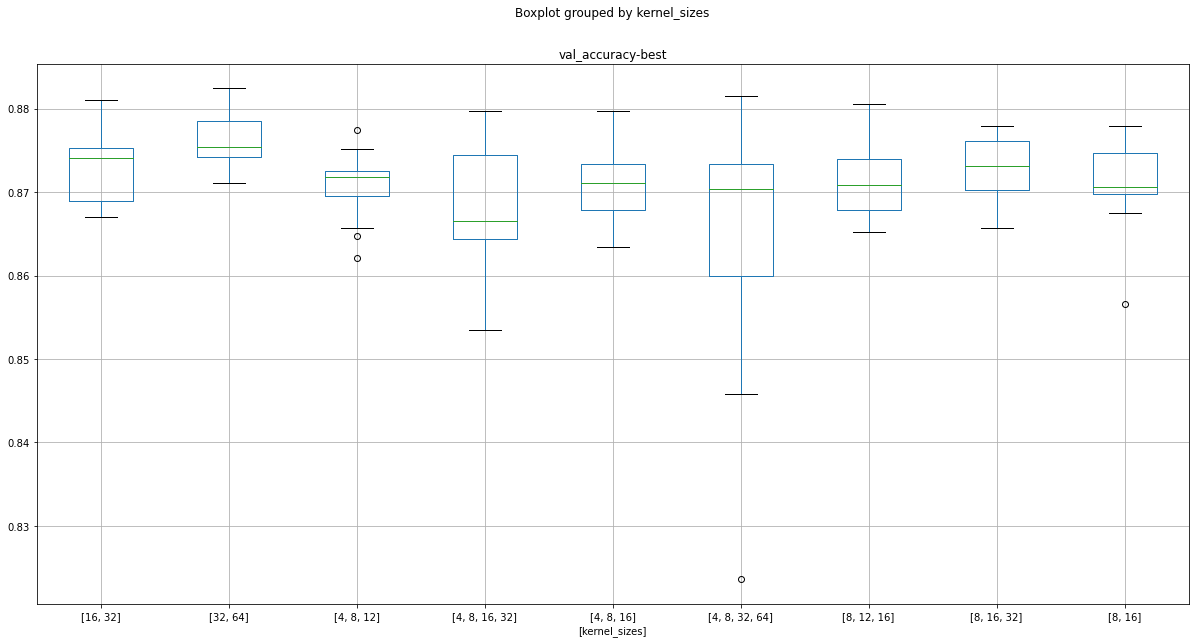

In [7]:
boxplot = df.boxplot(column=["val_accuracy-best"], by=['kernel_sizes'], figsize=(20,10))

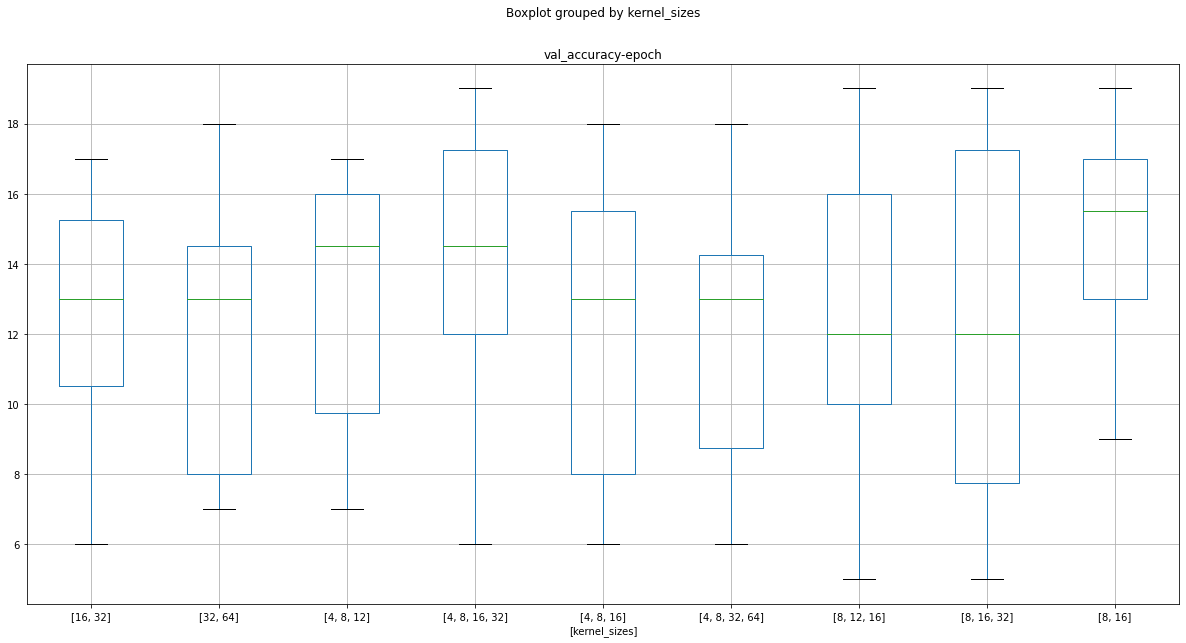

In [8]:
boxplot = df.boxplot(column=["val_accuracy-epoch"], by=['kernel_sizes'], figsize=(20,10))


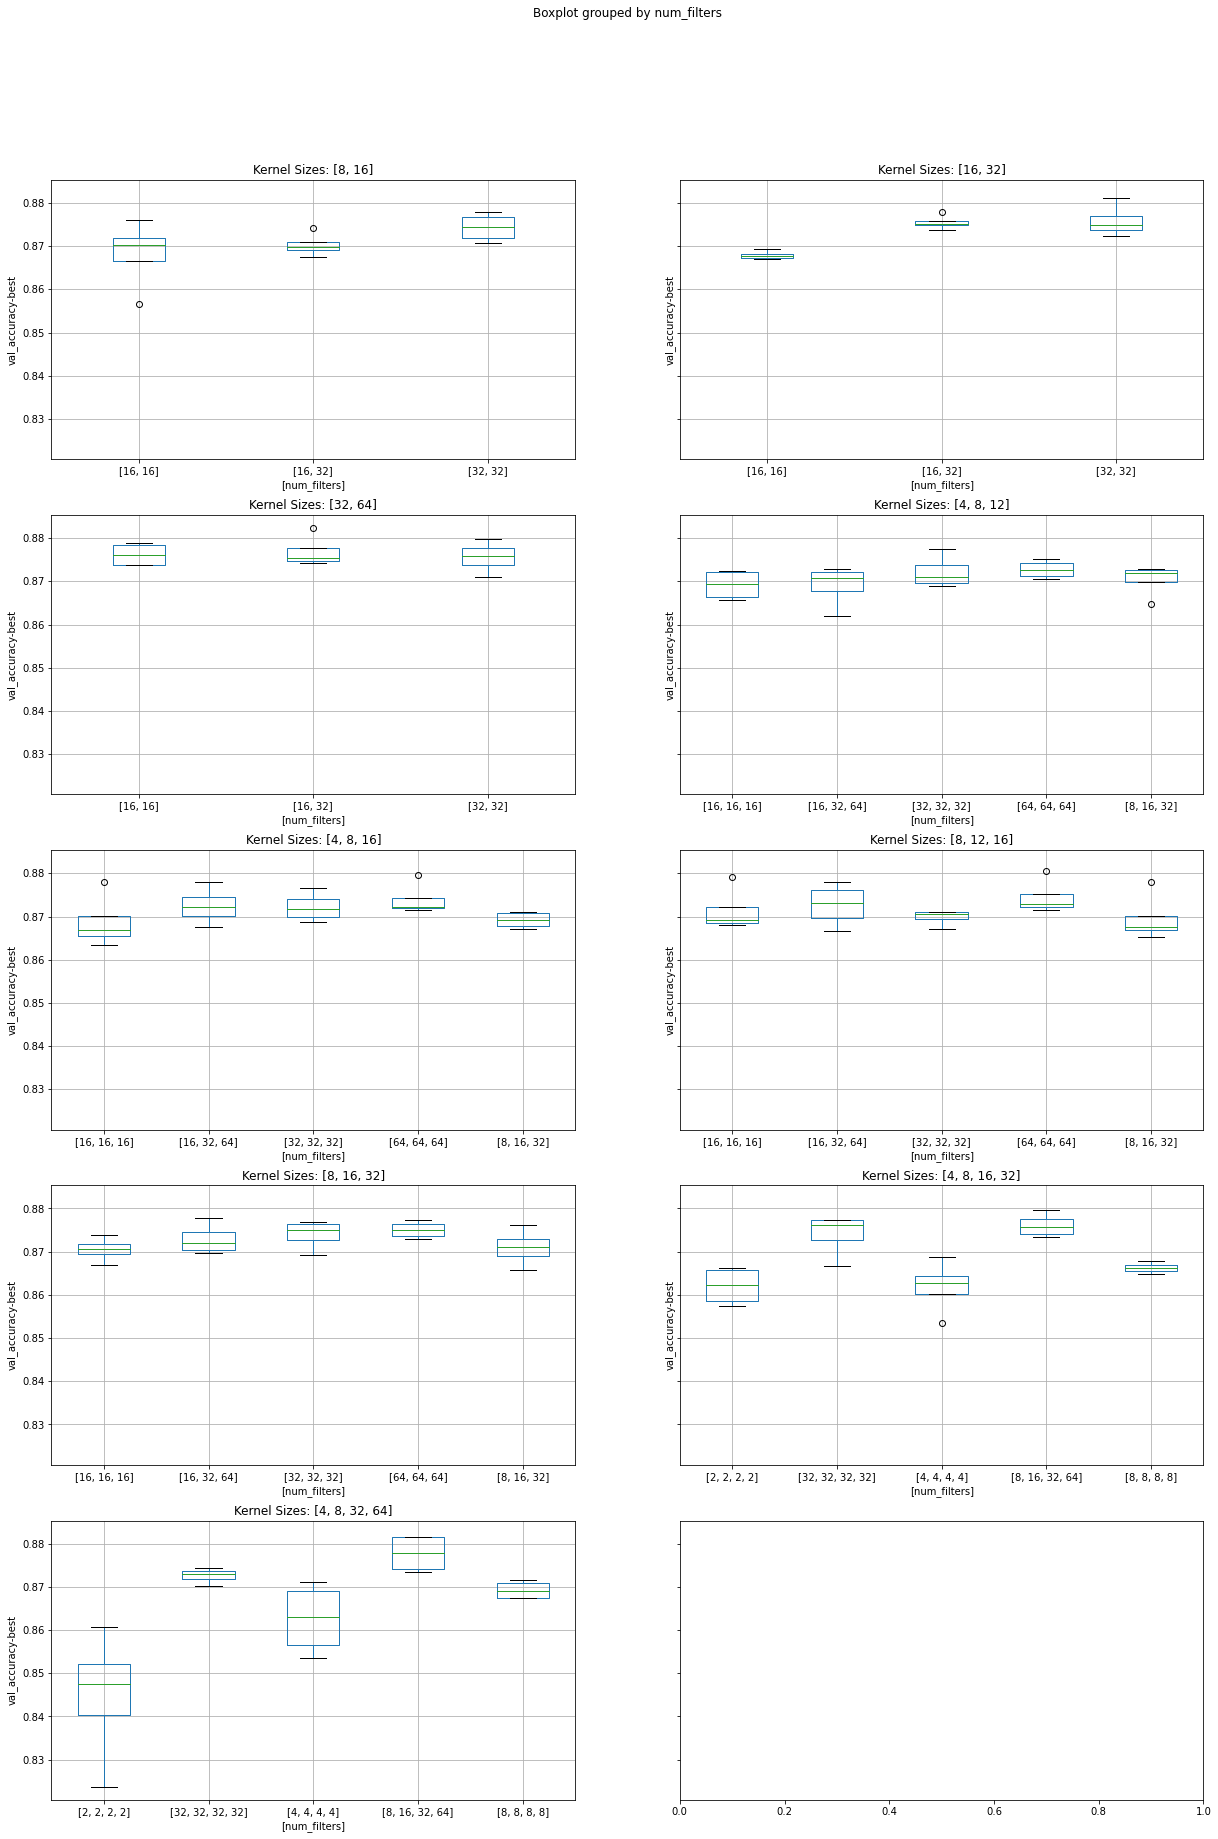

In [9]:
# look at each set of kernel sizes by their counts

kernels = df.kernel_sizes.unique()

# create 3-wide subplots to show
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 30), sharey=True)

for i in range(0,len(kernels)):
      
    x = i // 2
    y = i % 2
    
    axis = ax[x,y]
    
    axis.set_ylabel("val_accuracy-best")

    # plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    boxplot = df[df.kernel_sizes == kernels[i]].boxplot(column=["val_accuracy-best"],
                                                          by=['num_filters'],
                                                          ax=axis,
                                                          figsize=(20,10))
    axis.title.set_text(f"Kernel Sizes: {kernels[i]}")


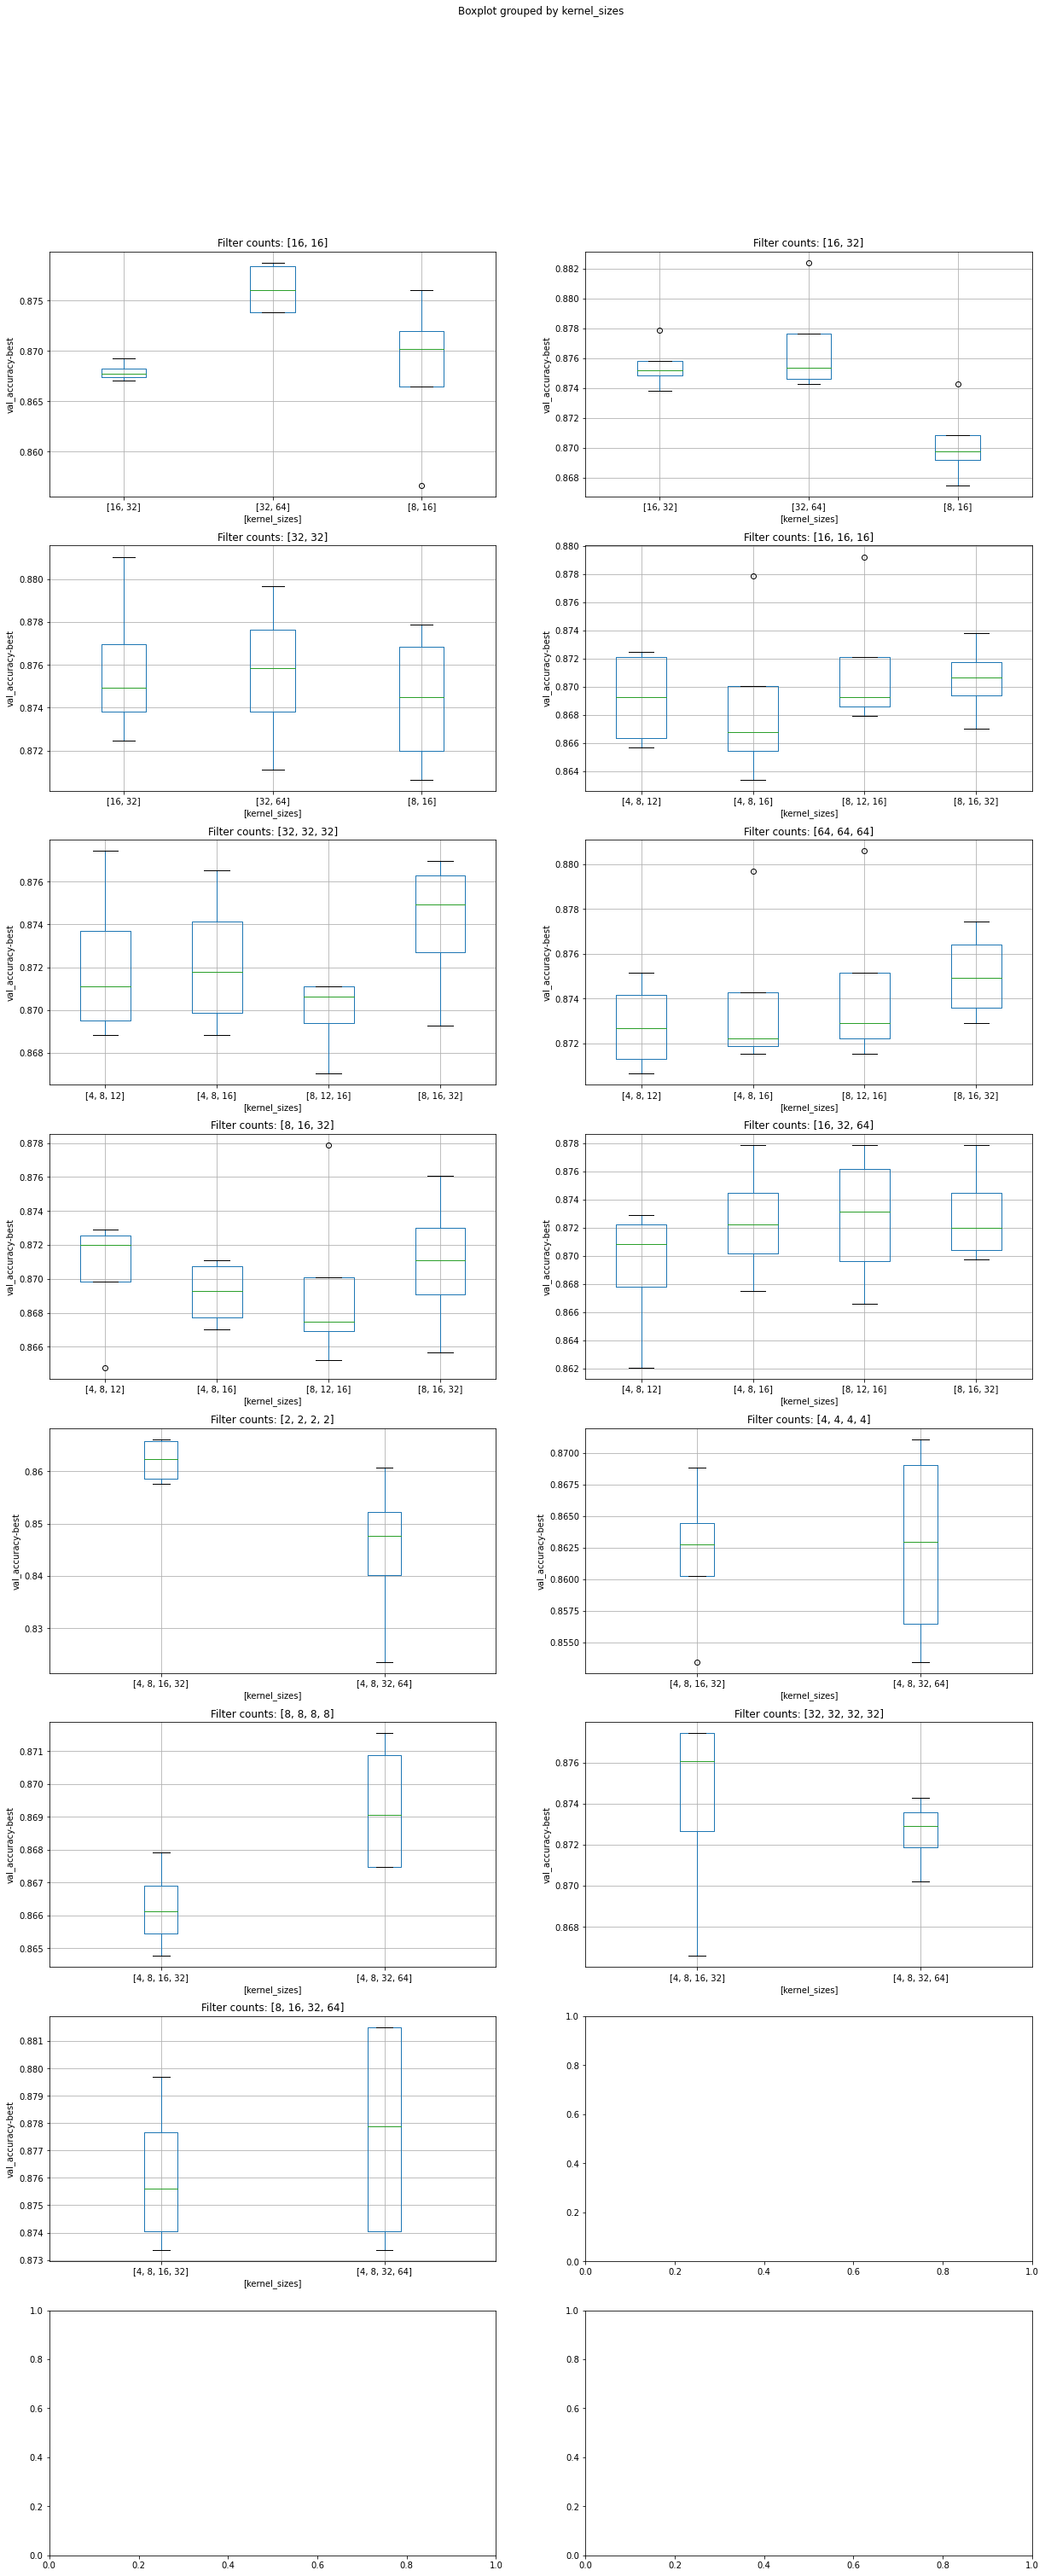

In [10]:
# look at each set of filter counts by their kernel sizes

filters = df.num_filters.unique()

# create 3-wide subplots to show
# fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 50), sharey=True)
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 50), sharey=False)

for i in range(0,len(filters)):
      
    x = i // 2
    y = i % 2
    
    axis = ax[x,y]
    
    axis.set_ylabel("val_accuracy-best")

    # plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    boxplot = df[df.num_filters == filters[i]].boxplot(column=["val_accuracy-best"],
                                                          by=['kernel_sizes'],
                                                          ax=axis,
                                                          figsize=(20,10))
    axis.title.set_text(f"Filter counts: {filters[i]}")


**In all of the cases we tried, the best accuracies came from the highest number of filters for each set of kernels, regardless of the kernel sizes:** ```[16,32]``` for the two-filter convolutions and ```[8,16,32]``` for the three-filter ones. We should therefore test even higher counts to see if that makes any marginal improvement, including ```[32,64]``` for the two-filter convolutions, and ```[16,32,63]``` for the three-filter ones.

**Equally, the largest filters generally produce the best results,** though there seems to be some fall off between ```[4,9,12]``` and ```[8,12,16]``` suggesting that a 4-word kernel does have value.  We should, in addition, test [4,8,16], [4,8,16,32] and other similar combinations to see if we can improve further.

## Evaluate the Dense Layers
Look at differences in the fully connected layers within the beset selections so far.

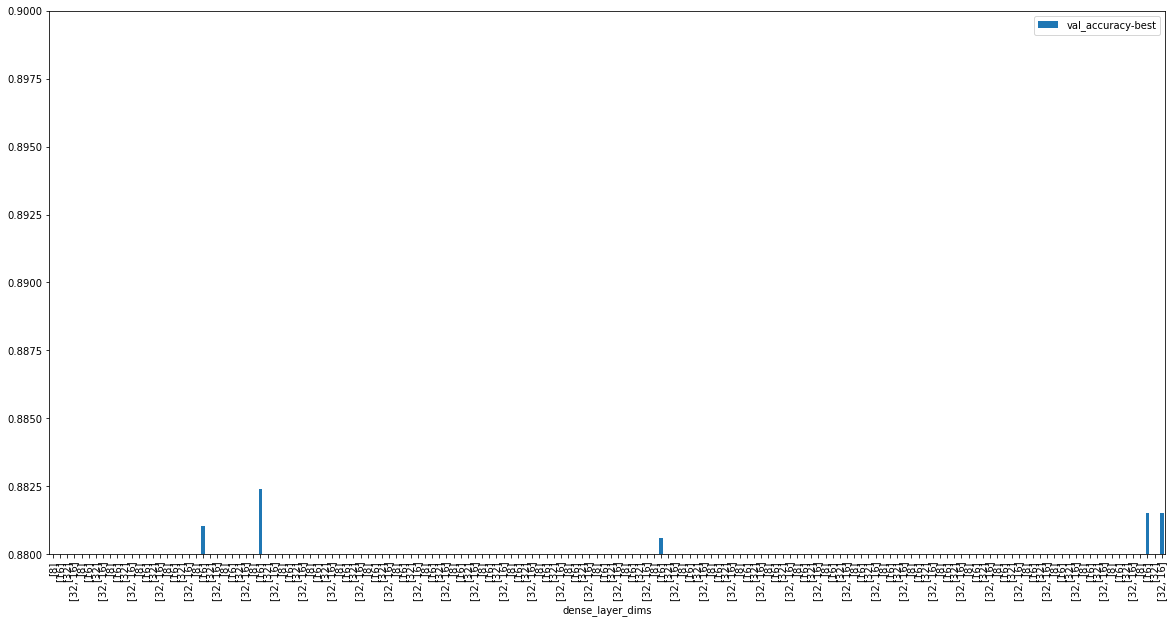

In [12]:
# look at accuracy by dense layers

boxplot = df.plot.bar(x="dense_layer_dims", y='val_accuracy-best', figsize=(20,10),ylim=(0.88,0.9))



**After selecting the best from the rest of the hyperparameters, the dense layers have less of an effect (within 1% of accuracy) - a single layer of only 8 nodes appears to be sufficient to give a good result.**

As we have a relatively small data set for training - fewer than 7000 records in training, it may not be possible to effectively converge on larger dense-layer models.

We also may want to look at f1 instead of accuracy to be certain??

Round 1 testing was for 8280 tests with different hyperparameters in a total run time of 49h40m for an average of 1 test every 21.6s


In [ ]:
best_test = df3[ df3["dense_layer_dims"] == "[8]"].to_dict(orient='records')[0]


In [ ]:
## print out best version:

print(f"Best validation accuracy in first hyperparameter tuning run is {best_test['val_accuracy-best']:5f}, in epoch {best_test['val_accuracy-epoch']},  Run at: {best_test['timestamp']}")

print(f"Model:  num_filters: {best_test['num_filters']}, kernel_sizes: {best_test['kernel_sizes']},  dense_layer_dims: {best_test['dense_layer_dims']},  dropout_rate: {best_test['dropout_rate']}")

## TensorBoard Output

Looking at the tensorboard output, it appears that although the highest accuracy was attained by epoch 9, there was clear overfitting as the loss function for the validation set started to increase after epoch 4, and the peak accuracy seems to be an outlier vs. the smoothed curve.

**For future tests, we will only go to 5 epochs** unless we see evidence that more epochs might improve accuracy without overfitting.

![Key](Key.png)
![Accuracy](Accuracy.png)
![Loss](Loss.png)